In [ ]:
!pip install -q kaggle

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/

In [ ]:
!kaggle datasets download -d harrywang/wine-dataset-for-clustering

  0% 0.00/4.36k [00:00<?, ?B/s]
100% 4.36k/4.36k [00:00<00:00, 9.38MB/s]


In [ ]:
!unzip wine-dataset-for-clustering.zip

Archive:  wine-dataset-for-clustering.zip
  inflating: wine-clustering.csv     


In [ ]:
df = spark.createDataFrame(pd.read_csv('/content/wine-clustering.csv'))

In [ ]:
df.show(5)

+-------+----------+----+------------+---------+-------------+----------+--------------------+---------------+---------------+----+-----+-------+
|Alcohol|Malic_Acid| Ash|Ash_Alcanity|Magnesium|Total_Phenols|Flavanoids|Nonflavanoid_Phenols|Proanthocyanins|Color_Intensity| Hue|OD280|Proline|
+-------+----------+----+------------+---------+-------------+----------+--------------------+---------------+---------------+----+-----+-------+
|  14.23|      1.71|2.43|        15.6|      127|          2.8|      3.06|                0.28|           2.29|           5.64|1.04| 3.92|   1065|
|   13.2|      1.78|2.14|        11.2|      100|         2.65|      2.76|                0.26|           1.28|           4.38|1.05|  3.4|   1050|
|  13.16|      2.36|2.67|        18.6|      101|          2.8|      3.24|                 0.3|           2.81|           5.68|1.03| 3.17|   1185|
|  14.37|      1.95| 2.5|        16.8|      113|         3.85|      3.49|                0.24|           2.18|            7.

In [ ]:
df.describe()

DataFrame[summary: string, Alcohol: string, Malic_Acid: string, Ash: string, Ash_Alcanity: string, Magnesium: string, Total_Phenols: string, Flavanoids: string, Nonflavanoid_Phenols: string, Proanthocyanins: string, Color_Intensity: string, Hue: string, OD280: string, Proline: string]

In [ ]:
df.summary().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+
|summary|           Alcohol|        Malic_Acid|               Ash|      Ash_Alcanity|        Magnesium|     Total_Phenols|        Flavanoids|Nonflavanoid_Phenols|   Proanthocyanins|   Color_Intensity|                Hue|             OD280|           Proline|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+
|  count|               178|               178|               178|               178|              178|               178|               178|                 178|               178|               178|                178|   

In [ ]:
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols = df.columns, outputCol='features')

vector_df = vec_assembler.transform(df)

<Axes: >

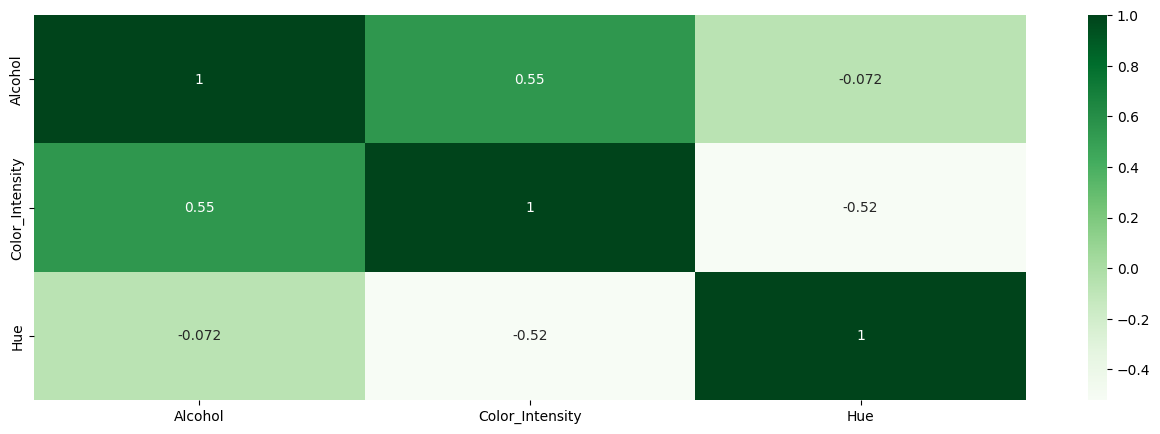

In [ ]:
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

matrix = Correlation.corr(vector_df, 'features').collect()[0][0]
corr_matrix_df = pd.DataFrame(matrix.toArray().tolist())

plt.figure(figsize=(16,5))
sns.heatmap(corr_matrix_df,
            xticklabels=df.columns,
            yticklabels=df.columns,  cmap="Greens", annot=True)

In [ ]:
temp=['Malic_Acid',
 'Ash',
 'Ash_Alcanity',
 'Magnesium',
 'Nonflavanoid_Phenols',
 'Proanthocyanins',
 'OD280',
 'Proline']
for _ in temp:
  df=df.drop(_)

In [ ]:
df.columns

['Alcohol', 'Color_Intensity', 'Hue']

In [ ]:
vector_df.show(5)

+-------+----------+----+------------+---------+-------------+----------+--------------------+---------------+---------------+----+-----+-------+
|Alcohol|Malic_Acid| Ash|Ash_Alcanity|Magnesium|Total_Phenols|Flavanoids|Nonflavanoid_Phenols|Proanthocyanins|Color_Intensity| Hue|OD280|Proline|
+-------+----------+----+------------+---------+-------------+----------+--------------------+---------------+---------------+----+-----+-------+
|  14.23|      1.71|2.43|        15.6|      127|          2.8|      3.06|                0.28|           2.29|           5.64|1.04| 3.92|   1065|
|   13.2|      1.78|2.14|        11.2|      100|         2.65|      2.76|                0.26|           1.28|           4.38|1.05|  3.4|   1050|
|  13.16|      2.36|2.67|        18.6|      101|          2.8|      3.24|                 0.3|           2.81|           5.68|1.03| 3.17|   1185|
|  14.37|      1.95| 2.5|        16.8|      113|         3.85|      3.49|                0.24|           2.18|            7.

In [ ]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features",
                        outputCol="scaledFeatures",
                        withStd=True,
                        withMean=False)

scalerModel = scaler.fit(vector_df)

final_df = scalerModel.transform(vector_df)

In [ ]:
final_df.select('scaledFeatures').show(5)

+--------------------+
|      scaledFeatures|
+--------------------+
|[17.5283750084766...|
|[16.2596310690015...|
|[16.2103594597015...|
|[17.7008256410266...|
|[16.3089026783015...|
+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]

evaluator = ClusteringEvaluator(predictionCol='prediction',
								featuresCol='scaledFeatures', \
								metricName='silhouette',
								distanceMeasure='squaredEuclidean')

for _ in range(2,10):
	kmeans=KMeans(featuresCol='scaledFeatures', k=_)
	model=kmeans.fit(final_df)
	predictions=model.transform(final_df)
	score=evaluator.evaluate(predictions)
	silhouette_score.append(score)
	print('Silhouette Score for k =', _, 'is', score)

Silhouette Score for k = 2 is 0.5120543195767812
Silhouette Score for k = 3 is 0.5841530765077722
Silhouette Score for k = 4 is 0.5597174522487752
Silhouette Score for k = 5 is 0.5445525163651159
Silhouette Score for k = 6 is 0.5075326814380295
Silhouette Score for k = 7 is 0.4790413399401191
Silhouette Score for k = 8 is 0.4350226256708012
Silhouette Score for k = 9 is 0.4722246595344717


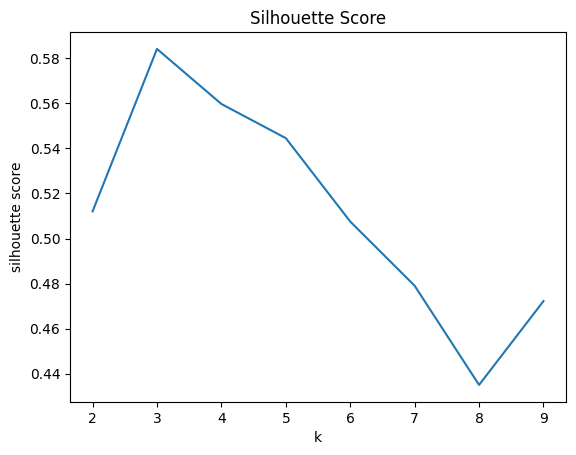

In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt

plt.plot(range(2,10), silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()

In [ ]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=3)
model = kmeans.fit(final_df)
predictions = model.transform(final_df)

In [ ]:
predictions.show(5)

+-------+---------------+----+-----------------+--------------------+----------+
|Alcohol|Color_Intensity| Hue|         features|      scaledFeatures|prediction|
+-------+---------------+----+-----------------+--------------------+----------+
|  14.23|           5.64|1.04|[14.23,5.64,1.04]|[17.5283750084766...|         0|
|   13.2|           4.38|1.05| [13.2,4.38,1.05]|[16.2596310690015...|         0|
|  13.16|           5.68|1.03|[13.16,5.68,1.03]|[16.2103594597015...|         0|
|  14.37|            7.8|0.86| [14.37,7.8,0.86]|[17.7008256410266...|         0|
|  13.24|           4.32|1.04|[13.24,4.32,1.04]|[16.3089026783015...|         0|
+-------+---------------+----+-----------------+--------------------+----------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(final_df)
pca_transformed = pca_model.transform(final_df)

In [ ]:
pca_transformed.show(5)

+-------+---------------+----+-----------------+--------------------+--------------------+
|Alcohol|Color_Intensity| Hue|         features|      scaledFeatures|                 pca|
+-------+---------------+----+-----------------+--------------------+--------------------+
|  14.23|           5.64|1.04|[14.23,5.64,1.04]|[17.5283750084766...|[-8.3600934945842...|
|   13.2|           4.38|1.05| [13.2,4.38,1.05]|[16.2596310690015...|[-6.9178940842410...|
|  13.16|           5.68|1.03|[13.16,5.68,1.03]|[16.2103594597015...|[-8.1819164941621...|
|  14.37|            7.8|0.86| [14.37,7.8,0.86]|[17.7008256410266...|[-10.509558978399...|
|  13.24|           4.32|1.04|[13.24,4.32,1.04]|[16.3089026783015...|[-6.8678576753233...|
+-------+---------------+----+-----------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [ ]:
cluster_assignment = np.array(predictions.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

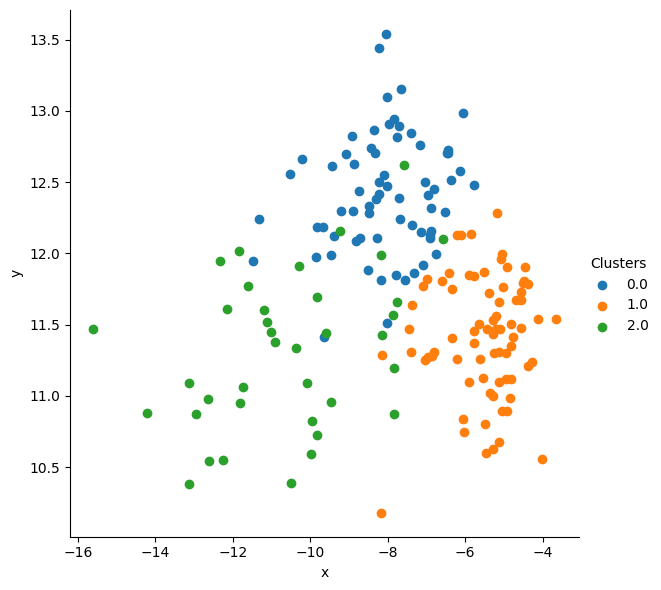

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("x", "y","Clusters"))
sns.FacetGrid(pca_df,hue="Clusters", height=6).map(plt.scatter, 'x', 'y' ).add_legend()

plt.show()

In [ ]:
import os
import sys
import re
import random
import types
import math

from pprint import pprint
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import *

from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd
import numpy as np
from time import time
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [ ]:
!unzip /content/drive/MyDrive/csv_files.zip

Archive:  /content/drive/MyDrive/csv_files.zip
replace artists.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
sqlContext = SQLContext(sc)
base = "/content/"

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='true') \
    .load(base + "user_artist.csv", schema = userArtistDataSchema)

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()
userArtistDF.show(20)

+------+--------+---------+
|userID|artistID|playCount|
+------+--------+---------+
|     1|       1|     1254|
|     1|       2|      452|
|     1|       3|      411|
|     1|       4|      394|
|     1|       5|      340|
|     1|       6|      339|
|     1|       7|      331|
|     1|       8|      265|
|     1|       9|      248|
|     1|      10|      223|
|     1|      11|      194|
|     1|      12|      188|
|     1|      13|      185|
|     1|      14|      183|
|     1|      15|      180|
|     1|      16|      159|
|     1|      17|      152|
|     1|      18|      151|
|     1|      19|      150|
|     1|      20|      149|
+------+--------+---------+
only showing top 20 rows



In [ ]:
distinctUsers = userArtistDF.select('userID').distinct().count()
duplicateUsers = userArtistDF.select('userID').count()
print("Total n. of valid records for users: ", duplicateUsers)
print("Total n. of distinct users:          ", distinctUsers)

Total n. of valid records for users:  106716
Total n. of distinct users:           1223


In [ ]:
df = spark.createDataFrame(pd.read_csv('/content/user_artist.csv'))

In [ ]:
artists = spark.createDataFrame(pd.read_csv('/content/artists.csv',
                                       encoding='latin-1')\
                                       [['artist_id', 'name']])

In [ ]:
artists.show(5)

+---------+-----------------+
|artist_id|             name|
+---------+-----------------+
|        1|       Andy Shauf|
|        2|         Lykke Li|
|        3|The Rubberbandits|
|        4|      Angel Olsen|
|        5|    Elliott Smith|
+---------+-----------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.recommendation import ALS

(training, test) = df.randomSplit([.8, .2])

als = ALS(maxIter=5, rank=4, regParam=0.01, userCol='user_id',
          itemCol='artist_id', ratingCol='playcount', coldStartStrategy='drop')

model=als.fit(training)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='playcount', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print(rmse)

346.696801427737


In [ ]:
predictions.show(10)

+-------+---------+---------+----------+
|user_id|artist_id|playcount|prediction|
+-------+---------+---------+----------+
|    243|     6658|       21| 1.0907149|
|    623|     2366|        8| 12.783647|
|    858|      496|       59| 6.9864845|
|    255|      496|       43| 123.68954|
|   1005|     1238|      244|  690.0542|
|     34|     1580|       36| 29.716408|
|    211|     1645|       50|  16.82492|
|    842|     8592|        4|-1.5934348|
|     27|     1088|       11|104.441734|
|    984|     1342|      294|  316.3343|
+-------+---------+---------+----------+
only showing top 10 rows



In [ ]:
df.filter(df.user_id == 918).show(5)

+-------+---------+---------+
|user_id|artist_id|playcount|
+-------+---------+---------+
|    918|       18|      101|
|    918|       63|      184|
|    918|       93|       42|
|    918|       94|      159|
|    918|       97|       26|
+-------+---------+---------+
only showing top 5 rows



In [ ]:
def current_likes(ua, ub, user_id, limit):
  temp = ua.join(ub,ua.artist_id==ub.artist_id)\
  .filter(ua.user_id == user_id)\
  .sort(ua.playcount.desc())\
  .select(ua.user_id, ua.playcount, ub.name)\
  .limit(limit)
  return temp


current_likes(df, artists, 2, 10).show(truncate=False)

+-------+---------+-------------------+
|user_id|playcount|name               |
+-------+---------+-------------------+
|2      |685      |Kanye West         |
|2      |321      |The Magnetic Fields|
|2      |292      |Vincent Gallo      |
|2      |210      |Bruce Springsteen  |
|2      |200      |Eels               |
|2      |186      |Vampire Weekend    |
|2      |183      |The Smiths         |
|2      |173      |Elliott Smith      |
|2      |165      |The Mountain Goats |
|2      |146      |Randy Newman       |
+-------+---------+-------------------+



In [ ]:
def recommendedArtists(ub, userId,limit):
  test =  model.recommendForAllUsers(limit).filter(col('user_id')==userId).select("recommendations").collect()
  topArtists = []
  for item in test[0][0]:
    topArtists.append(item.artist_id)
    schema = StructType([StructField("artist_id",IntegerType(),True)])
    artists = spark.createDataFrame(topArtists,IntegerType())
    final=artists.join(ub,artists.value==ub.artist_id).select(ub.artist_id,ub.name)
  return final
# display top 10 recommended artists for user 2062243
recommendedArtists(artists, 2, 10).show(truncate=False)

+---------+--------------------+
|artist_id|name                |
+---------+--------------------+
|14111    |Sleepy Eyes Of Death|
|2825     |Three Days Grace    |
|22355    |T.M.Revolution      |
|6608     |Amber Run           |
|15447    |Roald Dahl          |
|20708    |Josh Record         |
|21532    |The Plums           |
|1386     |Stephen King        |
|3722     |Daniel Johnston     |
|10040    |Romina Falconi      |
+---------+--------------------+



In [ ]:
import numpy as np
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix

In [ ]:
a = csr_matrix((1000000, 1000000), dtype = np.int8)

In [ ]:
b = csc_matrix((1000000, 1000000), dtype = np.int8)

In [ ]:
c = csr_matrix((1000000, 1), dtype = np.int8)

In [ ]:
d = csr_matrix((1000000, 1), dtype = np.int8)

In [ ]:
%%timeit
a.multiply(a)

6.71 ms ± 945 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
b.multiply(b)

7.06 ms ± 2.79 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
a.multiply(b)

17.7 ms ± 6.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
b.multiply(a)

13.4 ms ± 3.06 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
a.dot(c)

3.57 ms ± 98.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
a.dot(d)

3.57 ms ± 66.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
b.dot(c)

1.95 ms ± 395 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%%timeit
b.dot(d)

2.9 ms ± 339 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%whos
a

Variable     Type          Data/Info
------------------------------------
a            csr_matrix    
b            csc_matrix    
c            csr_matrix    
csc_matrix   type          <class 'scipy.sparse._csc.csc_matrix'>
csr_matrix   type          <class 'scipy.sparse._csr.csr_matrix'>
d            csr_matrix    
np           module        <module 'numpy' from '/us<...>kages/numpy/__init__.py'>


<1000000x1000000 sparse matrix of type '<class 'numpy.int8'>'
	with 0 stored elements in Compressed Sparse Row format>

In [ ]:
import sys
print(f'a: {sys.getsizeof(a)}\nb: {sys.getsizeof(b)}\n'
      f'c: {sys.getsizeof(c)}\nd: {sys.getsizeof(d)}\n')

a: 48
b: 48
c: 48
d: 48



In [ ]:
sys.getsizeof(b.multiply(a))

48

In [ ]:

import psutil
print('RAM memory % used:', psutil.virtual_memory()[2])
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM memory % used: 16.0
RAM Used (GB): 1.820151808
